# Machine Learning Education Projects:

* ## Image Captioning Problem

* ## Text Generation Problem
 
### *Disclaimer:*
* #### *Hardware:*
* ###### CPU: Intel Core i5-7300HQ
* ###### RAM: 16 GB
* ###### GPU: Nvidia GTX 1050 | 2GB
* #### *Keras Backend: Tensorflow 2.1 GPU*
* #### *On this kernel, all models are already trained and loaded; however, Training specs are displayed for evidence purposes and metric visualization.* 

## Image Captioning

### model based on [Image Captioning with Keras](https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8)
### Missing data from the challenge was acquiered from [Common Objects in Context website](https://cocodataset.org/#download)
### datasets:
#### Number of Training Images: 82783
#### Number of Validation Images: 40504
#### Number of Testing Images: 5000

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf

Using TensorFlow backend.


In [3]:
folder = 'codelab/train2014/'
dataset = os.listdir(folder)
dataset = [folder+data for data in dataset]
for data in dataset:
    if '.jpg' not in data:
        print(data)
print(len(dataset))

folder = 'codelab/val2014/'
validation = os.listdir(folder)
validation = [folder+data for data in validation]
for data in validation:
    if '.jpg' not in data:
        print(data)
print(len(validation))

folder = 'codelab/val2017/'
test = os.listdir(folder)
test = [folder+data for data in test]
for data in test:
    if '.jpg' not in data:
        print(data)
print(len(test))

82783
40504
5000


### From the Data Exploration Kernel, we take the files created for the captions and add *SOS* and *EOS* labels.

#### SOS: Start of Sentence
#### EOS: End of Sentence

In [4]:
folder = 'codelab/'

with open(folder + 'tr_captions.txt', 'r') as f:
    data = f.read().split('\n')
    
data = [[d.split()[0], ' '.join(d.split()[1:])] for d in data]
tr_caps = dict()
for id_, cap in data:
    if id_ not in tr_caps.keys():
        tr_caps[id_] = list()
    cap = 'SOS ' + cap + ' EOS'
    tr_caps[id_].append(cap)
    
with open(folder + 'v_captions.txt', 'r') as f:
    data = f.read().split('\n')
    
data = [[d.split()[0], ' '.join(d.split()[1:])] for d in data]
v_caps = dict()
for id_, cap in data:
    if id_ not in v_caps.keys():
        v_caps[id_] = list()
    cap = 'SOS ' + cap + ' EOS'
    v_caps[id_].append(cap)
    
    

### Given that the datasets are relatively massive, two strategies are followed:
- #### Serialize data
- #### Use generator functions in the Training/Validation process to save memory usage. (Explained on training section)

### Serializing images with a GPU takes around 6 hours and, with CPU, around 12 hours. To spare that time, files are already saved and ready to simply be loaded. On this markdown, however, I share the serializing script as evidence and for code review. 


```python
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

# Load the inception v3 model
model = InceptionV3(weights='imagenet')
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

encoding_train = {}
for img in tqdm(dataset):
    encoding_train[img[len('codelab/train2014/'):]] = encode(img)

# Save the bottleneck train features to disk
with open("codelab/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)
    
train_features = load(open("codelab/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))
    
encoding_test = {}
for img in tqdm(validation):
    encoding_test[img[len('codelab/val2014/'):]] = encode(img)

# Save the bottleneck test features to disk
with open("codelab/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)
    
test_features = load(open("codelab/encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))

encoding_final = {}
for img in tqdm(test):
    encoding_final[img[len('codelab/val2017/'):]] = encode(img)
  
with open("codelab/encoded_final_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_final, encoded_pickle)
#    
final_features = load(open("codelab/encoded_final_images.pkl", "rb"))
print('Photos: test=%d' % len(final_features))

```

In [5]:
# Load serialized preprocessed images

train_features = load(open("codelab/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))
#%store train_features

test_features = load(open("codelab/encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))
#%store test_features

final_features = load(open("codelab/encoded_final_images.pkl", "rb"))
print('Photos: final=%d' % len(final_features))
#store final_features

Photos: train=82783
Photos: test=40504
Photos: final=5000


### As aforementioned on the Data Exploration Kernel, to exclude outlier words, those which incidence is solely once, will be removed. 

In [6]:
from collections import Counter

voc_tr = ''
for k, caps in tr_caps.items():
    voc_tr += ' ' + ' '.join(caps) + ' '
voc_tr = Counter(voc_tr.split()).most_common()

new_voc_tr = list(filter(lambda x : x[1]>1, voc_tr))

voc_v = ''
for k, caps in v_caps.items():
    voc_v += ' ' + ' '.join(caps) + ' '
voc_v = Counter(voc_v.split()).most_common()

new_voc_v = list(filter(lambda x : x[1]>1, voc_v))

print(len(new_voc_tr), len(new_voc_v))

14112 10629


### Tokenization

#### We've been working with two dataset so far: Training and Validation; however, i'm going to join both's vocabularies to embed them at once. 

#### The common ix2word/word2ix convention will be harnessed. 

#### ```max_length = 50``` is concluded form the Data Exploration Kernel

#### Gobal Vectors (GloVe) Embedding will be used, through the [glove.6B.200d](https://www.kaggle.com/incorpes/glove6b200d) database. It has 6 billion words embedded in 200-D vectors. It was developed by the GloVe method creators Jeffrey Pennington, Richard Socher, and Christopher D. Manning. [Source](https://nlp.stanford.edu/projects/glove/)


In [7]:
# join vocabularies, captions and preprocessed images

new_voc = new_voc_tr + new_voc_v
caps, features = {**tr_caps, **v_caps}, {**train_features, **test_features}
print(len(new_voc), len(caps), len(features))

24741 123287 123287


In [8]:
ixtoword = {}
wordtoix = {}

ix = 1
for w, _ in new_voc:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
    
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

max_length = 50

In [9]:
glove_dir = 'glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [10]:
embedding_dim = 200

# Get 200-dim dense vector for each word in our vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape

(24742, 200)

### Keras Model Architecture

#### For the images analysis, a transfered learning strategy takes place invoking Google's Inception V.3 model. This model is for classification, which is not what we're intended to do; therefore, the last layer is dropped (where the classification happens) and we continue from the last layer's output vector of 2048-D. 

#### Concurrently a text generator model will be running taking in the current text sequence, bidding the embedding transformations and outputing a 24,742-D vector (vocabulary length)

#### The following image explains the overall model.

<img src="codelab/model_arch.jpeg" width="700" height="700"/>

#### The second part of the model construction follows the next code. 

```python
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

model.layers[2]
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam')
```

### Generator Function

#### Too much memory?, lets see: 
#### We have more than 120,000 images with 5 captions, on average, with 10 words each, on average. That gives 6,000,000 data points in an initial stage. 
#### the data matrix size is $ n*m $, where *n* is our estimate number of data points and *m* is the length of each data point. *m* incluedes the 2048-D vector, but it also incluedes de 200-D word embedding through sequences with a max. length of 50 words. *i.e*, $ m = 2048 + (200 * 50) = 12048 $.
#### data matrix size $= 6,000,000 * 12,048 = 72,288,000,000$Blocks
#### Let's say that each block takes 2 bytes, this will require 33.66 GB of memory, which I don't have. 

#### So, with a generator, instead of bringing all into memory and then processing it, we can generate batches of data mantaining the learning flow and a low memory usage. 

In [11]:
# generator
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            try:
                photo = photos['COCO_train2014_'+key+'.jpg']
            except:
                photo = photos['COCO_val2014_'+key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

#### After several trials, I was unsatisfied with the results, so I merged the training and validation data and splitted it manually. I chose a valildation set proportion of 25%.

#### There is too much data, so there is no need to run many EPOCHs, otherwise, the model might be highly prone to overfit. I chose 5 EPOCHs and after the 3rd EPOCH, the Learning rate decreases from 0.001 to 0.0001. 

#### Just for tunning the model a bit more, afterwards, another 2 EPOCHs were run, but trained only on the validation set at learning rate of 0.0001 to prevent overfitting. 

#### this process took more than 3 hours. To spare this time, the models are already saved and ready to simply be loaded. However, here's the script and a screenshot of the learning process as evidence and for code review.
```python
import random
val_prop = 0.25
caps_tr, caps_v = dict(), dict()

for k, cap in caps.items():
    if random.random() <= val_prop: caps_v[k] = cap
    else: caps_tr[k] = cap

print('training data: {} \nvalidation data: {}'.format(len(caps_tr), len(caps_v)))

epochs = 5
number_pics_per_bath = 10
steps_tr = len(caps_tr)//number_pics_per_bath
steps_v = len(caps_v)//number_pics_per_bath

for i in range(epochs):
    
    gen = data_generator(caps_tr, features, wordtoix, max_length, number_pics_per_bath)
    gen_v = data_generator(caps_v, features, wordtoix, max_length, number_pics_per_bath)

    if i > 3:
        def scheduler(_):
            return 0.0001
        callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    else:
        def scheduler(_):
            return 0.001
        callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
            
    
    model.fit_generator(gen,
                    epochs=1,
                    steps_per_epoch=steps_tr, verbose=1,
                    callbacks = [callback],
                    validation_data=gen_v,
                    validation_steps=steps_v)
    
    model.save('codelab/models/model_val25_' + str(i) + '.h5')
```
<img src="codelab/model_training.jpg" width="700" height="600"/>

```python
epochs = 2
number_pics_per_bath = 10
steps_v = len(caps_v)//number_pics_per_bath

for i in range(epochs):
    
    gen_v = data_generator(caps_v, features, wordtoix, max_length, number_pics_per_bath)

    def scheduler(_):
        return 0.0001
    callback = tf.keras.callbacks.LearningRateScheduler(scheduler)        
    
    model.fit_generator(gen_v,
                    epochs=1,
                    steps_per_epoch=steps_v, verbose=1,
                    callbacks = [callback])
    
    model.save('codelab/models/model_val25_' + str(5 + i) + '.h5')
```
<img src="codelab/model_training_2.jpg" width="700" height="600"/>

In [12]:
model = tf.keras.models.load_model('codelab/models/model_val25_6.h5')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 200)      4948400     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_1[0][0]                    
____________________________________________________________________________________________

In [13]:
def greedySearch(photo):
    in_text = 'SOS'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'EOS':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

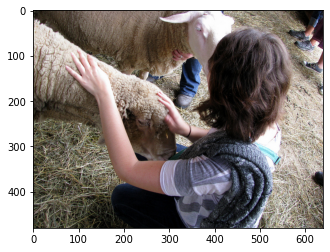

Greedy: 000000458755.jpg 
	  a man is holding a teddy bear in his hand


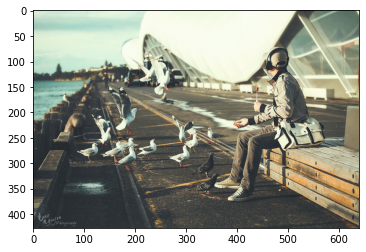

Greedy: 000000511076.jpg 
	  a man riding a skateboard down a street


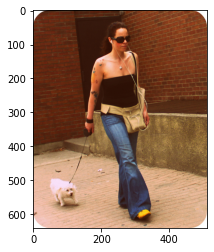

Greedy: 000000295478.jpg 
	  a man is holding a cell phone in his hand


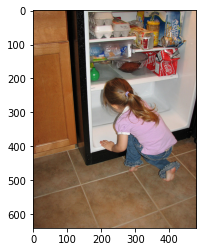

Greedy: 000000231339.jpg 
	  a woman is standing in front of a refrigerator


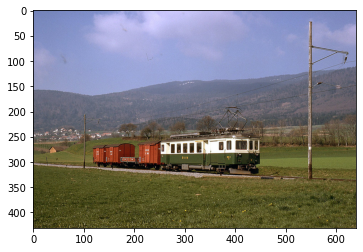

Greedy: 000000050165.jpg 
	  a train is parked on the tracks in front of a building


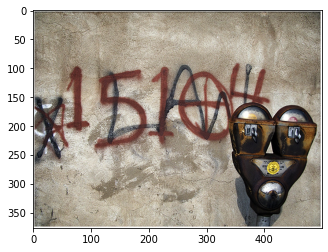

Greedy: 000000280325.jpg 
	  a person holding a cell phone in their hand


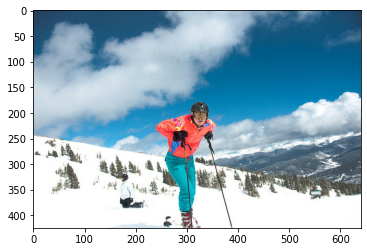

Greedy: 000000322724.jpg 
	  a man in a red jacket is skiing down a hill


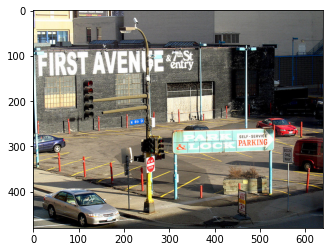

Greedy: 000000499181.jpg 
	  a group of people walking down a street


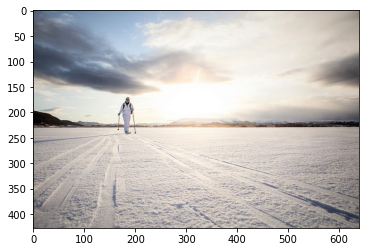

Greedy: 000000220764.jpg 
	  a person flying a kite in the air


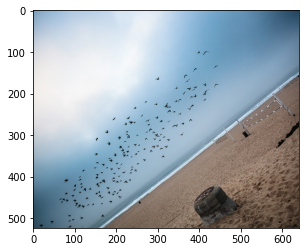

Greedy: 000000147498.jpg 
	  a man is flying a kite in the sky


In [14]:
import random
for _ in range(10):
    z = random.choice(range(len(final_features)))
    pic = list(final_features.keys())[z]
    image = final_features[pic].reshape((1,2048))
    x=plt.imread('codelab/val2017/'+pic)
    plt.imshow(x)
    plt.show()
    print("Greedy: {} \n\t ".format(pic),greedySearch(image))

In [15]:
import pandas as pd
import numpy as np

f = 'codelab/Image_Captions_Test.xlsx'
df = []

for k, pic in tqdm(final_features.items()):
    
    cap = greedySearch(pic.reshape(1,2048))
    df.append([k, cap])
    
df = pd.DataFrame(df, columns = ['Image File', 'Description'])
df.to_excel(f)


C:\Users\ramur\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


## Text Generation
### model based on [Beginners Guide to Text Generation using LSTMs](https://www.kaggle.com/shivamb/beginners-guide-to-text-generation-using-lstms/data?select=ArticlesApril2017.csv)

### Databases explained beforehand on the Data Exploration Kernel

#### Number of Headlines: 19,289
#### For Number of Keywords: 218


In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 


import pandas as pd
import numpy as np
import string, os 

Using TensorFlow backend.


In [3]:
with open('codelab/newsHL.txt', 'r') as f:
    newts = [line.strip() for line in f.read().split('\n')]
    
print('Number of Training Headlines: ', len(newts))

Number of Training Headlines:  19289


In [12]:
newts = [' '.join(['SOS', n, 'EOS']) for n in newts]
newts[:10]

['SOS sugars in western diets increase risk for breast cancer tumors and metastasis EOS',
 'SOS researchers reduce stem cell dysfunction metabolic disease in aged mice EOS',
 'SOS overweight young people can avoid diabetes risk if they lose weight early enough says new research EOS',
 'SOS powerful protein promotes post injury regeneration and growth of injured peripheral nerves EOS',
 'SOS insulin producing pancreatic cells created from human skin cells EOS',
 'SOS benefits of regular mammography extend to the elderly study suggests EOS',
 'SOS another reason why your diet is doomed hunger neurons promote negative feelings EOS',
 'SOS epigenetic regulation of metastatic breast cancer progression may guide prognosis future therapy EOS',
 'SOS study reveals potential therapy targets for triple negative breast cancer EOS',
 'SOS too much sugar there s an enzyme for that EOS']

#### Cleaning data for missing punctuation marks
#### n_grams tokenization for sequence generation

In [13]:
def clean_text(txt):
    txt = "".join(v for v in txt if v not in string.punctuation).lower()
    txt = txt.encode("utf8").decode("ascii",'ignore')
    return txt 

corpus = [clean_text(x.lower()) for x in newts]


In [14]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(corpus)


In [15]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

### Model

```python
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = create_model(max_sequence_len, total_words)
#model.summary()

epochs = 20
model.fit(predictors, label, epochs=epochs, verbose=1)
model.save('models/model_19K_{}.h5'.format(epochs))
```

<img src="codelab/model_training_3.jpg" width="700" height="600"/>

In [17]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()

    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=input_len))

    # Add Hidden Layer 1 - LSTM Layer
    model.add(LSTM(100))
    model.add(Dropout(0.1))

    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

model = create_model(max_sequence_len, total_words)
#model.summary()

epochs = 3
model.fit(predictors, label, epochs=epochs, verbose=1)
model.save('models/model_19K_L_{}.h5'.format(epochs))

C:\Users\ramur\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/3
179962/179962 [==============================] - 188s 1ms/step - loss: 7.1532
Epoch 2/3
179962/179962 [==============================] - 198s 1ms/step - loss: 6.5811
Epoch 3/3
179962/179962 [==============================] - 187s 1ms/step - loss: 6.2048


OSError: Unable to create file (unable to open file: name = 'models/model_19K_L_3.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

In [20]:
#model = tf.keras.models.load_model('codelab/models/model_19k_20.h5')
model.summary()

#def generate_text(seed_text, next_words, model, max_sequence_len):
#    for _ in range(next_words):
#        token_list = tokenizer.texts_to_sequences([seed_text])[0]
#        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
#        predicted = model.predict_classes(token_list, verbose=0)
#        
#        output_word = ""
#        for word,index in tokenizer.word_index.items():
#            if index == predicted:
#                output_word = word
#                break
#        seed_text += " "+output_word
#    return seed_text.title()
#
def generate_text(seed_text, model, max_sequence_len):
    output_word = ''
    while output_word != 'eos':
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()    

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 25, 10)            161110    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               44400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16111)             1627211   
Total params: 1,832,721
Trainable params: 1,832,721
Non-trainable params: 0
_________________________________________________________________


In [21]:
#import random

f = 'codelab/generated_HL_Test.xlsx'
df = []

for kw in ['sos acupuncture', 'sos antibiotics', 'sos bypass', 'sos hospital', 'sos nausea', 'sos prescription', 'sos surgery', 'sos treatment']:
    #r = random.randint(10,15)
    #hl = generate_text(kw, r, model, max_sequence_len)
    hl = generate_text(kw, model, max_sequence_len)
    print(hl)
    
    df.append([kw, hl])

df = pd.DataFrame(df, columns = ['Keyword', 'Headline'])
df
#df.to_excel(f)

Sos Acupuncture Of Diabetes Drug May Be In Us Eos
Sos Antibiotics Of The The World Eos
Sos Bypass With Diabetes Patients May Be Likely To Diabetes Risk Eos
Sos Hospital Says New Coronavirus Cases To Coronavirus Cases To Coronavirus Cases Eos
Sos Nausea May Be Likely To Be Pain Of Diabetes Eos
Sos Prescription To Help Diabetes Drug In Breast Cancer Eos
Sos Surgery Of The The World Eos
Sos Treatment Of The The New York Eos


,Keyword,Headline
0,sos acupuncture,Sos Acupuncture Of Diabetes Drug May Be In Us Eos
1,sos antibiotics,Sos Antibiotics Of The The World Eos
2,sos bypass,Sos Bypass With Diabetes Patients May Be Likel...
3,sos hospital,Sos Hospital Says New Coronavirus Cases To Cor...
4,sos nausea,Sos Nausea May Be Likely To Be Pain Of Diabete...
5,sos prescription,Sos Prescription To Help Diabetes Drug In Brea...
6,sos surgery,Sos Surgery Of The The World Eos
7,sos treatment,Sos Treatment Of The The New York Eos


# Create a file for both problems

In [10]:
writer = pd.ExcelWriter('codelab/output_files_.xlsx', engine='xlsxwriter')

xlsx = [
    'codelab/Image_Captions_Test.xlsx',
    'codelab/generated_HL_Test.xlsx'
]
for f in xlsx:
    df1 = pd.read_excel(f)
    df1.to_excel(writer, sheet_name=f.replace('.xlsx', '').replace('codelab/', ''))

writer.save()